# Import Package

In [1]:
from datetime import datetime, timedelta
import ephem
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator
import numpy as np
import pandas as pd
import requests
from suntimes import SunTimes
import xml.etree.ElementTree as ET

# Fetch Observation Data from MPEC/MPC

Guided by the following [Documentation from the MPEC](https://minorplanetcenter.net/mpcops/documentation/observations-api/) with object designation CK24G030 found in [MPEC 2024-U268](https://minorplanetcenter.net/mpec/K24/K24UQ8.html). The MPEC Observations API outputs in XML format. XML to Pandas DataFrame parser made by ChatGPT. Data in indices 206, 208, and 209 are extreme outliers and excluded so it will not interfere with the magnitude fittings. From MPEC, I got 242 comet observation data where the magnitudes are recorded.

In [2]:
response_mpec = requests.get("https://data.minorplanetcenter.net/api/get-obs", json={"desigs": ["CK24G030"], "output_format":["XML"]})

if response_mpec.ok:
    xml_string = response_mpec.json()[0]['XML']
else:
    print("Error: ", response_mpec.status_code, response_mpec.content)
    
# Load the XML data
root = ET.fromstring(xml_string)

# Extract data from XML and convert it to a list of dictionaries
mpec_obs_data = []
for optical in root.findall('optical'):
    record_optical = {elem.tag: elem.text for elem in optical}
    mpec_obs_data.append(record_optical)

# Convert the list of dictionaries to a pandas DataFrame
mpec_obs_df = pd.DataFrame(mpec_obs_data)

# Display the DataFrame
#mpec_obs_df.columns
mpec_obs_df = mpec_obs_df[['obsTime','mag', 'rmsMag','ref']].copy()
mpec_obs_df.dropna(inplace=True, subset=['mag'])
mpec_obs_df.reset_index(inplace=True, drop=True)
mpec_obs_df.drop(mpec_obs_df.index[[206,208,209]],inplace=True)

In [3]:
pd.set_option('display.max_rows', 10)
mpec_obs_df

,obsTime,mag,rmsMag,ref
0,2024-04-05T06:19:43.32Z,19.21,0.132,MPC 172004
1,2024-04-05T06:45:44.93Z,18.82,0.106,MPC 172004
2,2024-04-05T06:51:43.31Z,18.79,0.075,MPC 172004
3,2024-04-05T07:09:49.67Z,18.89,0.087,MPC 172004
4,2024-04-05T07:19:57.88Z,18.42,0.132,MPC 172004
...,...,...,...,...
243,2024-10-21T18:14:39.552Z,12.5,NaN,NaN
244,2024-10-28T00:11:25.152Z,12.6,NaN,NaN
245,2024-12-02T08:26:35.520Z,9.8,NaN,MPEC 2024-X74
246,2024-12-02T08:28:40.800Z,9.8,NaN,MPEC 2024-X74


# Fetch Observation Data from COBS

Then, I fetch observation data from the Comet Observation database (COBS), guided by this documentation on the [Observation List API](https://cobs.si/help/cobs_api/observation_list_api/). The API outputs JSON strings that can be directly converted into a DataFrame by Pandas. We got 16 [comet C/2024 G3](https://cobs.si/comet/2525/) observation data from this source.

In [4]:
# URL to fetch JSON data
url_cobs = "https://cobs.si/api/obs_list.api?format=json&des=C/2024%20G3"

try:
    # Get the JSON data from the URL
    response_cobs = requests.get(url_cobs)
    response_cobs.raise_for_status()  # Check for HTTP errors

    # Parse the JSON response
    data_cobs = response_cobs.json()

    # Convert the JSON data to pandas DataFrame
    # Assuming the data has a key 'observations' that holds a list of observation records
    df_obs_cobs = pd.DataFrame(data_cobs['objects'])
    df_obs_cobs['reference'] = df_obs_cobs['observer'].apply(lambda x: x.get('icq_name'))

    # Display the DataFrame
    print(df_obs_cobs.columns)
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")

Index(['type', 'obs_date', 'comet', 'observer', 'location', 'extinction',
       'obs_method', 'comet_visibility', 'magnitude', 'conditions',
       'ref_catalog', 'instrument_aperture', 'instrument_type',
       'instrument_focal_ratio', 'instrument_power', 'coma_visibility',
       'coma_diameter', 'coma_notes', 'coma_dc', 'tail_visibility',
       'tail_length', 'tail_length_unit', 'tail_pa', 'icq_reference',
       'icq_revision', 'comparison_field', 'integration_time',
       'photometry_aperture_shape', 'photometry_aperture_size',
       'photometry_aperture_unit', 'camera_type', 'chip_type', 'software_type',
       'image_correction', 'observation_published', 'image_number',
       'image_coadded', 'magnitude_error', 'comparison_star_magnitude',
       'pixel_size_x', 'pixel_size_y', 'pixel_size_unit', 'obs_comment',
       'obs_sky_quality', 'obs_sky_quality_method', 'reference_star_names',
       'date_added', 'reference'],
      dtype='object')


In [5]:
df_obs_cobs = df_obs_cobs[['obs_date','magnitude','magnitude_error','reference']].copy()
df_obs_cobs.rename(columns={"obs_date": "obsTime", "magnitude": "mag", "magnitude_error":"rmsMag", "reference":"ref"}, inplace=True)
# Convert ObsTime in df2 to match the format of df1
df_obs_cobs['obsTime'] = pd.to_datetime(df_obs_cobs['obsTime']).dt.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
# Remove trailing zeros in the microseconds part for consistency (if needed)
df_obs_cobs['obsTime'] = df_obs_cobs['obsTime'].str.replace(r'(\.\d{2})(\d{4,6})Z$', r'\1Z', regex=True)
df_obs_cobs

,obsTime,mag,rmsMag,ref
0,2024-12-10T08:23:59.00Z,8.5,0.05,LOV
1,2024-12-08T08:23:59.00Z,8.9,None,JAM02
2,2024-12-07T08:23:59.00Z,8.9,None,JAM02
3,2024-12-06T08:23:59.00Z,9.1,None,JAM02
4,2024-12-05T08:23:59.00Z,9.3,None,JAM02
...,...,...,...,...
21,2024-08-26T02:24:00.00Z,16.2,None,YOS02
22,2024-07-31T19:55:11.00Z,16.4,None,LEH02
23,2024-07-11T18:35:00.00Z,16.5,None,PAP04
24,2024-07-07T19:55:12.00Z,17.2,None,LEH02


# Combine Observation Data and Color-coding For Plotting

We combine observation data from MPEC and COBS into one dataframe, with colour-coding applied to differentiate the data sources (<span style="font-weight: bold;">black for MPEC</span> and and <span style="font-weight: bold; color: #069af3;">blue for COBS</span>).

In [6]:
comet_obs_frames = [df_obs_cobs, mpec_obs_df]
comet_obs_all = pd.concat(comet_obs_frames)
comet_obs_all.sort_values(by=['obsTime'], inplace=True, ignore_index=True)

# Convert 'obsTime' to datetime format
comet_obs_all['obsTime'] = pd.to_datetime(comet_obs_all['obsTime'], format='mixed')
comet_obs_all['mag'] = pd.to_numeric(comet_obs_all['mag'])
comet_obs_all['rmsMag'] = pd.to_numeric(comet_obs_all['rmsMag'])

# Define condition for coloring based on 'ref'
comet_obs_all['ref'] = comet_obs_all['ref'].apply(str)
comet_obs_all['color'] = comet_obs_all['ref'].apply(lambda x: 'black' if 'MPC' in x or 'MPEC' in x else 'xkcd:azure')
comet_obs_all

,obsTime,mag,rmsMag,ref,color
0,2024-04-05 06:19:43.320000+00:00,19.21,0.132,MPC 172004,black
1,2024-04-05 06:45:44.930000+00:00,18.82,0.106,MPC 172004,black
2,2024-04-05 06:51:43.310000+00:00,18.79,0.075,MPC 172004,black
3,2024-04-05 07:09:49.670000+00:00,18.89,0.087,MPC 172004,black
4,2024-04-05 07:19:57.880000+00:00,18.42,0.132,MPC 172004,black
...,...,...,...,...,...
266,2024-12-05 08:23:59+00:00,9.30,NaN,JAM02,xkcd:azure
267,2024-12-06 08:23:59+00:00,9.10,NaN,JAM02,xkcd:azure
268,2024-12-07 08:23:59+00:00,8.90,NaN,JAM02,xkcd:azure
269,2024-12-08 08:23:59+00:00,8.90,NaN,JAM02,xkcd:azure


# Fetch Orbital Parameters from COBS in Ephem Format

This section uses the capability offered by COBS' [Orbital Elements API](https://cobs.si/help/cobs_api/elements_api/), which can output [XEphem format](https://xephem.github.io/XEphem/Site/help/xephem.html#mozTocId468501) directly usable by the `ephem` [Python module](https://rhodesmill.org/pyephem/quick.html).

In [7]:
# Define the URL
url_orbit_c2024 = "https://cobs.si/api/elements.api?format=ephem&des=C/2024%20G3"

# Make the GET request
response_orbit_c2024g3 = requests.get(url_orbit_c2024)

# Check if the request was successful (status code 200)
if response_orbit_c2024g3.status_code == 200:
    # Get the response text
    orbit_c2024g3 = response_orbit_c2024g3.text
    print(orbit_c2024g3)
else:
    print(f"Failed to retrieve data. Status code: {response_orbit_c2024g3.status_code}")

C/2024 G3 (ATLAS),h,01/13.4352/2025,116.8470,220.3375,108.1242,1.000004,0.093536,2000,9.0,4.0



Next, we calculate the comet-sun distance ($r_t$) and comet-Earth distance ($\Delta_t$) at the time $t$ when comet observations were made, all in the astronomical unit (AU), using `ephem`.

In [8]:
ephem_c2024_g3 = ephem.readdb(orbit_c2024g3)

# Define a function to compute distances
def compute_distances(row):
    ephem_c2024_g3.compute(row['obsTime'])
    return pd.Series([ephem_c2024_g3.sun_distance, ephem_c2024_g3.earth_distance])

# Apply the function to each row in the DataFrame
comet_obs_all[['comet_sun_distance', 'comet_earth_distance']] = comet_obs_all.apply(compute_distances, axis=1)
comet_obs_all

,obsTime,mag,rmsMag,ref,color,comet_sun_distance,comet_earth_distance
0,2024-04-05 06:19:43.320000+00:00,19.21,0.132,MPC 172004,black,4.652852,4.395285
1,2024-04-05 06:45:44.930000+00:00,18.82,0.106,MPC 172004,black,4.652649,4.394892
2,2024-04-05 06:51:43.310000+00:00,18.79,0.075,MPC 172004,black,4.652603,4.394802
3,2024-04-05 07:09:49.670000+00:00,18.89,0.087,MPC 172004,black,4.652463,4.394528
4,2024-04-05 07:19:57.880000+00:00,18.42,0.132,MPC 172004,black,4.652384,4.394376
...,...,...,...,...,...,...,...
266,2024-12-05 08:23:59+00:00,9.30,NaN,JAM02,xkcd:azure,1.181020,2.059266
267,2024-12-06 08:23:59+00:00,9.10,NaN,JAM02,xkcd:azure,1.159446,2.037553
268,2024-12-07 08:23:59+00:00,8.90,NaN,JAM02,xkcd:azure,1.137687,2.015513
269,2024-12-08 08:23:59+00:00,8.90,NaN,JAM02,xkcd:azure,1.115737,1.993144


# Finding H and n (Simple Fit)

According to [Hughes (1990)](https://adsabs.harvard.edu/full/1990acm..proc..327H), a comet's absolute magnitude $m_1$ can be expressed as follows, ignoring the effects of forward scattering:

$$m_1 = H + \left[5\times\log_{10}\left(\Delta_t\right)\right] + \left[2.5n\times\log_{10}\left(r_t\right)\right] \tag{1}$$

with $\Delta_t$ as the comet-Earth distance and $r_t$ as the comet-Sun distance, all in AU and calculated using `ephem` at the comet's observation time $t$. Thus, both $\left[5\times\log_{10}\left(\Delta_t\right)\right]$ and $\left[2.5\times\log_{10}\left(r_t\right)\right]$ are known. Meanwhile, $m_1$ is the observed comet's magnitude. Equation (1) above can be rearranged into a linear $y = Ax + C$ form, with

$$ y = m_1 - \left[5\times\log_{10}\left(\Delta_t\right)\right]$$
$$ x = \left[2.5\times\log_{10}\left(r_t\right)\right]$$

and $A = n$ and $C = H$. We can solve for $H$ and $n$ using linear regression or least-square methods. Here I write $H$ as `H_0` for some reason.

In [9]:
m1_minus_5logDelta = comet_obs_all['mag'].to_numpy() - (5*np.log10(comet_obs_all['comet_earth_distance'].to_numpy()))
logR_times_2x5 = 2.5*(np.log10(comet_obs_all['comet_sun_distance'].to_numpy()))

# Perform linear regression using numpy.polyfit
n, H_0 = np.polyfit(logR_times_2x5, m1_minus_5logDelta, 1)

print(f"Slope (n): {n}")
print(f"Intercept (H_0): {H_0}")

Slope (n): 5.29260989592695
Intercept (H_0): 7.125264584232561


Using `numpy.polyfit`, we got $H = 7.12$ and $n = 5.29$. $H$ is the comet's absolute magnitude, i.e. how bright the comet will be if it were 1 AU from the Sun <b>and</b> 1 AU from the Earth. The parameter $n$ is called the <i>slope factor</i>, describing how the comet's brightness will change as it approaches or leaves the sun in its orbit. The smaller the $H$ (i.e., moving toward $-\infty$), the brighter the comet. Also, the bigger the $n$, the quicker the comet brightens or dim as it go towards or departs from the perihelion (a point where the comet-Sun distance is closest).

# Finding H and n (Forward Scattering Fit)

In the forward scattering fit, we need to know the comet's phase angle. The phase angle is the angle subtended at the object of interest between the line connecting the object and the illuminating sun and the line connecting the object and the observer [(Fink & Doose, 2018)](https://www.sciencedirect.com/science/article/pii/S0019103517304190) or the angle between the direction of illumination and the direction of observation [(Hadamcik & Levasseur-Regourd, 2003)](https://www.sciencedirect.com/science/article/pii/S002240730200314X). To calculate the phase angle, we need to know three distances: Sun-comet distance ($r_t$), comet-Earth distance ($\Delta_t$), and Sun-Earth distance.

In [10]:
# Create an observer (e.g., on Earth)
observer = ephem.Observer()
observer.lat = '-36.8509'  # Latitude of observer (Auckland)
observer.lon = '174.7645'  # Longitude of observer (Auckland)
observer.elevation = 80  # Elevation in meters

comet_obs_scatter_fit = comet_obs_all.copy()

# Define a function to compute distances
def compute_dist_scatter(row):
    observer.date = row['obsTime']
    
    # Compute the position of the comet relative to the observer
    ephem_c2024_g3.compute(observer)
    
    # Get the Sun object and compute its position relative to the observer
    sun = ephem.Sun(observer)
    
    return pd.Series([ephem_c2024_g3.sun_distance, ephem_c2024_g3.earth_distance, sun.earth_distance])

# Apply the function to each row in the DataFrame
comet_obs_scatter_fit[['comet_sun_distance', 'comet_earth_distance', 'sun_earth_distance']] = comet_obs_scatter_fit.apply(compute_dist_scatter, axis=1)
comet_obs_scatter_fit

,obsTime,mag,rmsMag,ref,color,comet_sun_distance,comet_earth_distance,sun_earth_distance
0,2024-04-05 06:19:43.320000+00:00,19.21,0.132,MPC 172004,black,4.652852,4.395269,1.000498
1,2024-04-05 06:45:44.930000+00:00,18.82,0.106,MPC 172004,black,4.652649,4.394876,1.000508
2,2024-04-05 06:51:43.310000+00:00,18.79,0.075,MPC 172004,black,4.652603,4.394786,1.000510
3,2024-04-05 07:09:49.670000+00:00,18.89,0.087,MPC 172004,black,4.652463,4.394513,1.000516
4,2024-04-05 07:19:57.880000+00:00,18.42,0.132,MPC 172004,black,4.652384,4.394360,1.000520
...,...,...,...,...,...,...,...,...
266,2024-12-05 08:23:59+00:00,9.30,NaN,JAM02,xkcd:azure,1.181020,2.059268,0.985449
267,2024-12-06 08:23:59+00:00,9.10,NaN,JAM02,xkcd:azure,1.159446,2.037555,0.985304
268,2024-12-07 08:23:59+00:00,8.90,NaN,JAM02,xkcd:azure,1.137687,2.015515,0.985162
269,2024-12-08 08:23:59+00:00,8.90,NaN,JAM02,xkcd:azure,1.115737,1.993146,0.985024


The phase angle ($\theta$) is then calculated from the Sun-comet distance ($r_t$), comet-Earth distance ($\Delta_t$), and Sun-Earth distance using the [cosine rule](https://www.mathsisfun.com/algebra/trig-cosine-law.html).

$$\mathrm{Sun\; to\; Earth\; distance\; at\;}t=\sqrt{\Delta_t^{2}+r_t^{2}-\left(2 \cdot \Delta_t \cdot r_t \cdot \cos \theta\right)}$$

$$\frac{\Delta_t^{2}+r_t^{2}-\left(\mathrm{Sun\; to\; Earth\; distance\; at\;}t\right)^2}{2 \cdot \Delta_t \cdot r_t}=\cos\left(\theta\right)$$

$$\theta = \mathrm{acos}\left[\frac{\Delta_t^{2}+r_t^{2}-\left(\mathrm{Sun\; to\; Earth\; distance\; at\;}t\right)^2}{2 \cdot \Delta_t \cdot r_t}\right]$$

We can estimate the brightness contributed by the forward scattering of sunlight by cometary dusts using the following formula [(Marcus, 2007)](http://www.icq.eps.harvard.edu/marcus_icq29_119.pdf):

$$m_{\Phi\left(\theta\right)} = -2.5\times \log_{10}\left[\Phi\left(\theta\right)\right],$$

where $\Phi\left(\theta\right)$ is

$$\Phi(\theta) = \frac{\delta_{90}}{1 + \delta_{90}} \left[ k \left( \frac{1 + g_f^2}{1 + g_f^2 - 2g_f \cos\theta} \right)^{3/2} + (1 - k) \left( \frac{1 + g_b^2}{1 + g_b^2 - 2g_b \cos\theta} \right)^{3/2} + \frac{1}{\delta_{90}} \right]$$

with:
$$g_f = 0.9$$
$$g_b = -0.6$$
$$k = 0.95$$
$$\delta_{90} =\left\{\begin{matrix}
10 & \mathrm{for\;``dusty``\;comets}\\1 & \mathrm{for\;``usual``\;comets.}
\end{matrix}\right.$$

In this case, the formula for $m_1$ changes into the following form:

$$m_1 = H + \left[5\times\log_{10}\left(\Delta_t\right)\right] + \left[2.5n\times\log_{10}\left(r_t\right)\right] + m_{\Phi\left(\theta\right)}. \tag{2}$$

Thus, the linear equation for solving the $H$ and $n$ will have

$$ y = m_1 - \left[5\times\log_{10}\left(\Delta\right)\right] - m_{\Phi\left(\theta\right)}$$
$$ y = m_1 - \left[5\times\log_{10}\left(\Delta\right)\right] + \left\{2.5\times \log_{10}\left[\Phi\left(\theta\right)\right]\right\}.$$

The rest of the linear equation component have the same form as for the simple fit case.

In [11]:
def phi_phase_angle(delta_90, gf, gb, k, phase_angle_rad):
    mult_factor = delta_90/(1+delta_90)
    inside_bracket_left = k*np.power((1+(gf**2))/(1+(gf**2)-(2*gf*np.cos(phase_angle_rad))),1.5)
    inside_bracket_middle = (1-k)*np.power((1+(gb**2))/(1+(gb**2)-(2*gb*np.cos(phase_angle_rad))),1.5)
    inside_bracket_right = 1/delta_90
    return mult_factor*(inside_bracket_left + inside_bracket_middle + inside_bracket_right)

# Calculate the phase angle using the cosine rule
r = comet_obs_scatter_fit['comet_sun_distance'].to_numpy()
d = comet_obs_scatter_fit['comet_earth_distance'].to_numpy()
s = comet_obs_scatter_fit['sun_earth_distance'].to_numpy()
phase_angle_rad = np.arccos((r**2 + d**2 - s**2) / (2 * r * d))
phase_angle_deg = np.rad2deg(phase_angle_rad)
delta_90_A = 10 #dusty comet
delta_90_B = 1 #normal comet
gf = 0.9
gb = -0.6
k = 0.95

mag_scat_dusty = -2.5*np.log10(phi_phase_angle(delta_90_A, gf, gb, k, phase_angle_rad))
mag_scat_normal = -2.5*np.log10(phi_phase_angle(delta_90_B, gf, gb, k, phase_angle_rad))

m1_min_5logDelta_min_mphi_dusty = comet_obs_all['mag'].to_numpy() - (5*np.log10(comet_obs_all['comet_earth_distance'].to_numpy())) - mag_scat_dusty
m1_min_5logDelta_min_mphi_normal = comet_obs_all['mag'].to_numpy() - (5*np.log10(comet_obs_all['comet_earth_distance'].to_numpy())) - mag_scat_normal
logR_times_2x5 = 2.5*(np.log10(comet_obs_all['comet_sun_distance'].to_numpy()))

# Perform linear regression using numpy.polyfit
n_dusty, H_0_dusty = np.polyfit(logR_times_2x5, m1_min_5logDelta_min_mphi_dusty, 1)
n_normal, H_0_normal = np.polyfit(logR_times_2x5, m1_min_5logDelta_min_mphi_normal, 1)

print(f"Slope (n) dusty: {n_dusty}")
print(f"Intercept (H_0) dusty: {H_0_dusty}\n\n")
print(f"Slope (n) normal: {n_normal}")
print(f"Intercept (H_0) normal: {H_0_normal}")

Slope (n) dusty: 6.250709891879888
Intercept (H_0) dusty: 11.059004669657261


Slope (n) normal: 6.243452290974401
Intercept (H_0) normal: 10.427809888481237


Using `numpy.polyfit`, we got $H = 11.06$ and $n = 6.25$ for the "dusty" C/2024 G3 comet case and $H = 10.43$ and $n = 6.24$ for the "usual" C/2024 G3 comet case. These numbers are all higher than those obtained using the simple magnitude fit.

# Magnitude and Altitude Prediction

In this section, I predicted comet C/2024 G3 brightness magnitude using two scenarios: simple fit and dusty comet case. Both scenarios yield similar magnitude estimates that fall within observation uncertainty ($\pm1$ magnitude), except for a period spanning the November to December 2024, where the dusty scenario prediction is up to 2 magnitudes brighter than the simple fit scenario. Remember that a celestial object becomes brighter as its magnitude goes toward $-\infty$.

I also inquire the comet's altitude at 40 minutes <b>before sunrise</b> and <b>after sunset</b>, when I deem that the sky above Auckland has darkened enough to allow cometary observations. Sunrise and sunset times are calculated using `suntimes` package. Comet's altitude is not corrected for atmospheric refraction, which requires daily temperature and pressure averages for the observation site (which in this case, Auckland).

In [12]:
AKL_sunriseset = SunTimes(np.rad2deg(observer.long), np.rad2deg(observer.lat), observer.elevation)

In [13]:
# Step 1: Generate an array of dates from 1 April 2024 to 28 February 2025
start_date = datetime(2024, 4, 1)
end_date = datetime(2025, 2, 28)

# Create a list of dates
dates_proj = np.array([start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)])

# Initialize arrays to store results
proj_sun_distances = np.zeros(len(dates_proj))
proj_earth_distances = np.zeros(len(dates_proj))

# Step 3: Compute distances and magnitude
comet_altitude_40minSunRise = np.zeros(len(dates_proj))
comet_altitude_40minSunSet = np.zeros(len(dates_proj))
proj_magnitudes = np.zeros(len(dates_proj))
proj_mag_dusty = np.zeros(len(dates_proj))
proj_mag_normal = np.zeros(len(dates_proj))

# Loop through each date to compute distances and magnitudes
for i, date in enumerate(dates_proj):
    observer.date = date
    ephem_c2024_g3.compute(observer)  # Compute comet's position for the given date
    sun = ephem.Sun(observer) # Get the Sun object and compute its position relative to the observer
    comet_sun_distance = ephem_c2024_g3.sun_distance  # Distance to the Sun (r)
    comet_earth_distance = ephem_c2024_g3.earth_distance  # Distance to Earth (Δ)
    sun_earth_distance = sun.earth_distance # Sun-Earth distance for calculating phase angle
    phase_angle_rad = np.arccos((comet_sun_distance**2 + comet_earth_distance**2 - sun_earth_distance**2) / (2 * comet_sun_distance * comet_earth_distance))
    proj_mag_scat_dusty = -2.5*np.log10(phi_phase_angle(delta_90_A, gf, gb, k, phase_angle_rad))
    proj_mag_scat_normal = -2.5*np.log10(phi_phase_angle(delta_90_B, gf, gb, k, phase_angle_rad))
    
    # sunrise - 40 minutes
    sunrise_time_UTC_min30m = AKL_sunriseset.riseutc(date) - timedelta(hours=1, minutes=00)
    observer.date = sunrise_time_UTC_min30m
    ephem_c2024_g3.compute(observer)
    comet_altitude_40minSunRise[i] = ephem_c2024_g3.alt * (180.0 / ephem.pi)  # Convert radians to degrees
    
    # sunset + 40 minutes
    sunset_time_UTC_plus30m = AKL_sunriseset.setutc(date) + timedelta(hours=1, minutes=00)
    observer.date = sunset_time_UTC_plus30m
    ephem_c2024_g3.compute(observer)
    comet_altitude_40minSunSet[i] = ephem_c2024_g3.alt * (180.0 / ephem.pi)  # Convert radians to degrees
    
    # Store distances
    proj_sun_distances[i] = comet_sun_distance
    proj_earth_distances[i] = comet_earth_distance
    
    # Calculate magnitude using the given formula
    proj_magnitudes[i] = H_0 + (5 * np.log10(comet_earth_distance)) + ((2.5 * n) * np.log10(comet_sun_distance))
    proj_mag_dusty[i] = H_0_dusty + (5 * np.log10(comet_earth_distance)) + ((2.5 * n_dusty) * np.log10(comet_sun_distance)) + proj_mag_scat_dusty
    proj_mag_normal[i] = H_0_normal + (5 * np.log10(comet_earth_distance)) + ((2.5 * n_normal) * np.log10(comet_sun_distance)) + proj_mag_scat_normal
    
print(proj_magnitudes[:10])

[19.27905957 19.2548017  19.2304713  19.2060687  19.18159576 19.15705394
 19.13244495 19.1077703  19.08303166 19.0582305 ]


# Plotting

In [14]:
max(comet_altitude_40minSunSet.max(),comet_altitude_40minSunRise.max())

np.float64(60.0580172964622)

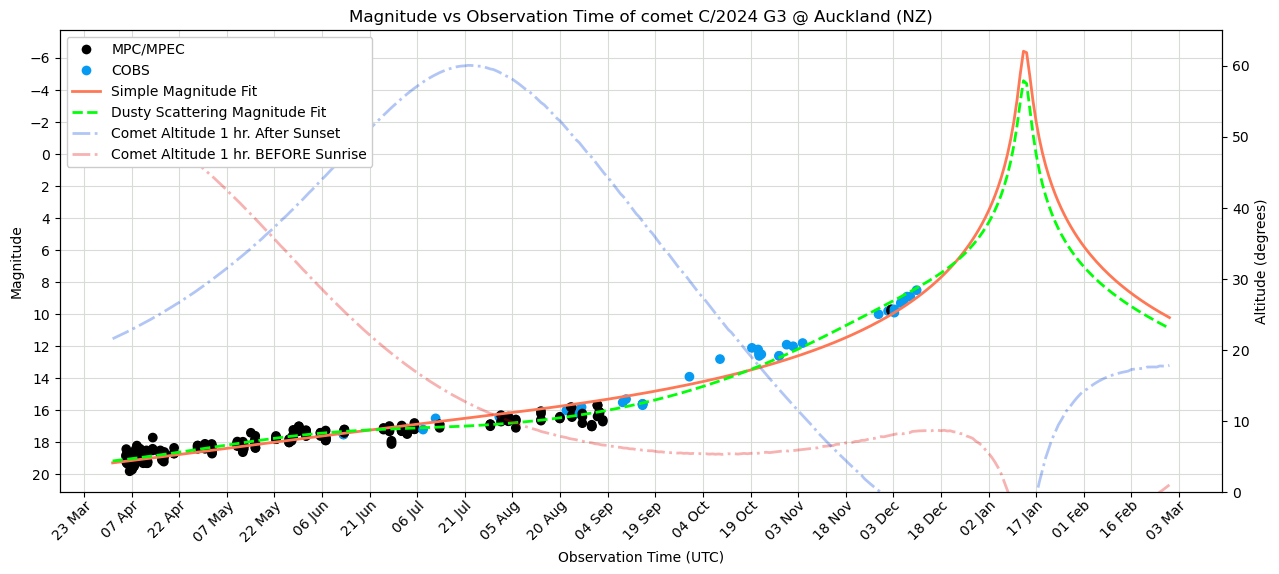

In [15]:
# Using fig and ax
fig, ax = plt.subplots(figsize=(15, 6))

# Scatter plot
ax.scatter(comet_obs_all['obsTime'], comet_obs_all['mag'], c=comet_obs_all['color'], label='Magnitude', zorder=5)
ax.plot(dates_proj, proj_magnitudes, label='Simple Magnitude Fit', linewidth=2, color='xkcd:melon', zorder=6)
ax.plot(dates_proj, proj_mag_dusty, label='Dusty Scattering Magnitude Fit', color='xkcd:bright green', linewidth=2, linestyle='--', zorder=7)
#ax.plot(dates_proj, proj_mag_normal, label='Normal Scattering Magnitude Fit', zorder=3, color='xkcd:soft pink', linewidth=2, linestyle='--')

# Customize the plot
ax.set_xlabel('Observation Time (UTC)')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs Observation Time of comet C/2024 G3 @ Auckland (NZ)')
ax.invert_yaxis()  # Invert y-axis since lower magnitude means brighter
ax.grid(True, zorder=0, color='xkcd:light gray')

# Use MaxNLocator to control the y-axis tick density
ax.yaxis.set_major_locator(FixedLocator(np.flip(np.arange(-6,22,2))))

# Set x-axis major ticks to every one month
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as 'Year-Month-day'
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', va='top', rotation_mode='anchor')
ax.tick_params(axis='x', pad=1)

# Step 3: Create the second y-axis for altitudes
ax2 = ax.twinx()

# Step 4: Plot the altitude curves on the second axis (ax2)
ax2.plot(dates_proj, comet_altitude_40minSunSet, color='xkcd:blue', linewidth=2, linestyle='-.', zorder=3, alpha=0.3)
ax2.plot(dates_proj, comet_altitude_40minSunRise, color='xkcd:red', linewidth=2, linestyle='-.', zorder=2, alpha=0.3)
ax2.set_ylabel('Altitude (degrees)', color='k')
ax2.tick_params(axis='y', colors='k')
ax2.set_ylim(0,round(max(comet_altitude_40minSunSet.max(),comet_altitude_40minSunRise.max()))+5)
#ax2.legend(loc='upper right')

# Adding legend for clarity
black_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='MPC/MPEC')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='xkcd:azure', markersize=8, label='COBS')
line_patch = plt.Line2D([0], [0], marker='none', color='xkcd:melon', linewidth=2, label='Simple Magnitude Fit')
scat_line_patch = plt.Line2D([0], [0], marker='none', color='xkcd:bright green', linewidth=2, linestyle='--', label='Dusty Scattering Magnitude Fit')
comet_alt_40minSunSet = plt.Line2D([0], [0], marker='none', color='xkcd:blue', linewidth=2, linestyle='-.', alpha=0.3, label='Comet Altitude 1 hr. After Sunset')
comet_alt_40minSunRise = plt.Line2D([0], [0], marker='none', color='xkcd:red', linewidth=2, linestyle='-.', alpha=0.3, label='Comet Altitude 1 hr. BEFORE Sunrise')
legend_box = ax2.legend(handles=[black_patch, blue_patch, line_patch, scat_line_patch, comet_alt_40minSunSet, comet_alt_40minSunRise], fancybox=True, loc='upper left', framealpha=1.0)
legend_box.set_zorder(10)

# Show the plot
plt.show()

# Conclusion

From this exercise, we can see that comet C/2024 G3 will be naked-eye observable as a morning comet in the first week of January 2025, then it will be lost in the sun's glare before reappearing low over the western horizon, naked-eye visible too, on 18 January 2025. Naked-eye evening observation of comet C/2024 G3 will be possible from dark places in the western coast of northern North Island (Karioitahi, Whatipu, Piha, Muriwai, Kaipara, up to Cape Reinga) from 18 January to 26 January 2025. Better chance of C/2024 G3 comet sight can be achieved by going near or to the equator.